# 网易云课堂《用Python做深度学习1——数学基础》

## 从公式理解卷积层的前向后向传播过程

作者：黑板客

转载请注明出处和作者

In [1]:
import numpy as np

%load_ext autoreload
%autoreload 2

# Convolution Layer Forward

卷积层的前向激活过程，我们首先忽略激活层。认为f(x)=x，那么纯卷积层的前向激活公式如下：

$$ \begin{array}\ ou{t_{n,f,ho,wo}} &= conv(XP,W,b,params)\\
&= \sum\limits_{c = 0,ho = 0,wo = 0}^{C - 1,Ho - 1,Wo - 1} {X{P_{n,c,ho*S + (1:HH),wo*S + (1:WW)}}*{W_{f,c,:,:}}}  + {b_f}\\
\end{array} $$

n是输入的个数，比如输入100张图片，n＝100.

C是input channel，比如输入的图片是RGB三通道的，C＝3.

S是stride，XP是填0后的输入。若不填0，则XP＝X.

F是filter number，系数的高和宽分别是HH，WW。Ho和Wo是输出的高，宽。

根据这个公式我们可以写出最基础的前向过程，理解原理不用担心你的for循环有几层，那些是以后优化的工作。理解了上面的公式，你就可以理解下面的实现代码。

In [2]:
# based on cs231n assignment2
def conv_forward_naive(x, w, b, conv_param):
  """
  A naive implementation of the forward pass for a convolutional layer.

  The input consists of N data points, each with C channels, height H and width
  W. We convolve each input with F different filters, where each filter spans
  all C channels and has height HH and width HH.

  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
      horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input.

  Returns a tuple of:
  - out: Output data, of shape (N, F, H', W') where H' and W' are given by
    H' = 1 + (H + 2 * pad - HH) / stride
    W' = 1 + (W + 2 * pad - WW) / stride
  - cache: (x, w, b, conv_param)
  """
  out = None
  #############################################################################
  # TODO: Implement the convolutional forward pass.                           #
  # Hint: you can use the function np.pad for padding.                        #
  #############################################################################
  N,C,H,W = x.shape
  F,_,HH,WW = w.shape
  S = conv_param['stride']
  P = conv_param['pad']
  Ho = 1 + (H + 2 * P - HH) / S
  Wo = 1 + (W + 2 * P - WW) / S
  x_pad = np.zeros((N,C,H+2*P,W+2*P))
  x_pad[:,:,P:P+H,P:P+W]=x
  #x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')
  out = np.zeros((N,F,Ho,Wo))

  for f in xrange(F):
    for i in xrange(Ho):
      for j in xrange(Wo):
        # N*C*HH*WW, C*HH*WW = N*C*HH*WW, sum -> N*1
        out[:,f,i,j] = np.sum(x_pad[:, :, i*S : i*S+HH, j*S : j*S+WW] * w[f, :, :, :], axis=(1, 2, 3)) 

    out[:,f,:,:]+=b[f]
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  cache = (x, w, b, conv_param)
  return out, cache

我们可以用几个例子试试它的输出

In [3]:
x_shape = (2, 3, 4, 4) #n,c,h,w
w_shape = (2, 3, 3, 3) #f,c,hw,ww
x = np.ones(x_shape)
w = np.ones(w_shape)
b = np.array([1,2])

conv_param = {'stride': 1, 'pad': 0}
out, _ = conv_forward_naive(x, w, b, conv_param)

print out
print out.shape  #n,f,ho,wo

[[[[ 28.  28.]
   [ 28.  28.]]

  [[ 29.  29.]
   [ 29.  29.]]]


 [[[ 28.  28.]
   [ 28.  28.]]

  [[ 29.  29.]
   [ 29.  29.]]]]
(2, 2, 2, 2)


自己计算一下结果，然后看看运行出来和你计算的是否一致。

设置pad为1，自己再计算一下结果。尤其是结果的维数变化。

设置stride为3，pad为1呢？

还可以怎么设置呢？

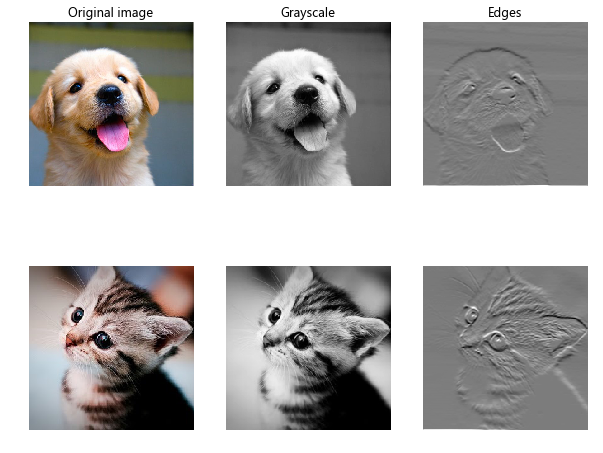

In [5]:
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d/2:-d/2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution Layer Backward

后向传播过程复杂一些，不过一旦你掌握了偏微分和链式法则，应该也难不倒你。

假设卷积层后直接跟了Loss层，那么

$$ \frac{{\partial L}}{{\partial w}} = \frac{{\partial L}}{{\partial out}}*\frac{{\partial out}}{{\partial w}} $$

$$ \frac{{\partial L}}{{\partial x}} = \frac{{\partial L}}{{\partial out}}*\frac{{\partial out}}{{\partial x}} $$

$$ \frac{{\partial L}}{{\partial b}} = \frac{{\partial L}}{{\partial out}}*\frac{{\partial out}}{{\partial b}} $$

而且

$$ \frac{{\partial L}}{{\partial out}} = dout $$

dout在卷积层的后向过程是已知的，所以公式看上去很简单，就是下标处理复杂了点。我们慢慢来继续推导它。


$$ \begin{array}\ \frac{{\partial L}}{{\partial {W_{f,c,:,:}}}} &= \sum\limits_{n = 0,ho = 0,wo = 0}^{N - 1,Ho - 1,Wo - 1} {dou{t_{n,f,ho,wo}}} *\frac{{\partial ({XP_{n,c,h_{win},w_{win}}}*{W_{f,c,:,:}}+b_f)}}{{\partial {W_{f,c,:,:}}}} \\
&= \sum\limits_{n = 0,ho = 0,wo = 0}^{N - 1,Ho - 1,Wo - 1} {dou{t_{n,f,ho,wo}}*{XP_{n,c,h_{win},w_{win}}}} \end{array} $$

为了简化期间，我们把偏导一个w，改成偏导一个w的二维矩阵，这样dout的偏微分就更好理解一些。对x的偏导我们也同样处理。其中XP的下标h_win，w_win是前向过程公式里ho*s+(1:HH)和wo*s+(1:WW)的缩写。


$$ \begin{array}\ \frac{{\partial L}}{{\partial {XP_{n,c,h_{win},w_{win}}}}} &= \sum\limits_{f = 0,ho = 0,wo = 0}^{F - 1,Ho - 1,Wo - 1} {dou{t_{n,f,ho,wo}}} *\frac{{\partial ({XP_{n,c,h_{win},w_{win}}}*{w_{f,c,:,:}}+b_f)}}{{\partial {X_{n,c,h_{win},w_{win}}}}} \\
&= \sum\limits_{f = 0,ho = 0,wo = 0}^{F - 1,Ho - 1,Wo - 1} {dou{t_{n,f,ho,wo}}*{W_{f,c,:,:}}} \end{array} $$

$$ \begin{array}\ \frac{{\partial L}}{{\partial {b_f}}} &= \sum\limits_{n = 0,ho = 0,wo = 0}^{N - 1,Ho - 1,Wo - 1} {dou{t_{n,f,ho,wo}}} *\frac{{\partial ({XP_{n,c,h_{win},w_{win}}}*{W_{f,c,:,:}}+b_f)}}{{\partial {b_f}}} \\ 
&= \sum\limits_{n = 0,ho = 0,wo = 0}^{N - 1,Ho - 1,Wo - 1} {dou{t_{n,f,ho,wo}}} \end{array} $$


理解了上面的公式，接下来我们再理解下面的实现代码就简单多了。

In [7]:
def conv_backward_naive(dout, cache):
  """
  A naive implementation of the backward pass for a convolutional layer.

  Inputs:
  - dout: Upstream derivatives.
  - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

  Returns a tuple of:
  - dx: Gradient with respect to x
  - dw: Gradient with respect to w
  - db: Gradient with respect to b
  """
  dx, dw, db = None, None, None
  #############################################################################
  # TODO: Implement the convolutional backward pass.                          #
  #############################################################################
  N, F, H1, W1 = dout.shape
  x, w, b, conv_param = cache
  N, C, H, W = x.shape
  HH = w.shape[2]
  WW = w.shape[3]
  S = conv_param['stride']
  P = conv_param['pad']


  dx, dw, db = np.zeros_like(x), np.zeros_like(w), np.zeros_like(b)
  x_pad = np.pad(x, [(0,0), (0,0), (P,P), (P,P)], 'constant')
  dx_pad = np.pad(dx, [(0,0), (0,0), (P,P), (P,P)], 'constant')
  db = np.sum(dout, axis=(0,2,3))
  
  for n in xrange(N):
    for i in xrange(H1):
      for j in xrange(W1):
        # Window we want to apply the respective f th filter over (C, HH, WW)
        x_window = x_pad[n, :, i * S : i * S + HH, j * S : j * S + WW]
        
        for f in xrange(F):
          dw[f] += x_window * dout[n, f, i, j] #F,C,HH,WW
          #C,HH,WW
          dx_pad[n, :, i * S : i * S + HH, j * S : j * S + WW] += w[f] * dout[n, f, i, j]
  
  dx = dx_pad[:, :, P:P+H, P:P+W]

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  return dx, dw, db

上面的实现代码是最原始的。
matlab上为了加速，使用已有的conv函数实现上述过程，才有了很多博文上提到的翻转180度两次的过程，翻来翻去的反而不容易理解整个过程。其实卷积层的前向和后向传播，跟信号处理的卷积操作没有直接关系。就是相关和点乘操作。其它实现都是优化加速方法。

我们对反向传播也举个例子

In [9]:
x_shape = (2, 3, 4, 4)
w_shape = (2, 3, 3, 3)
x = np.ones(x_shape)
w = np.ones(w_shape)
b = np.array([1,2])

conv_param = {'stride': 1, 'pad': 0}

Ho = (x_shape[3]+2*conv_param['pad']-w_shape[3])/conv_param['stride']+1
Wo = Ho

dout = np.ones((x_shape[0], w_shape[0], Ho, Wo))

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print "out shape",out.shape
print "dw=========================="
print dw
print "dx=========================="
print dx
print "db=========================="
print db


out shape (2, 2, 2, 2)
dw==========================
[[[[ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]

  [[ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]

  [[ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]]


 [[[ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]

  [[ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]

  [[ 8.  8.  8.]
   [ 8.  8.  8.]
   [ 8.  8.  8.]]]]
dx==========================
[[[[ 2.  4.  4.  2.]
   [ 4.  8.  8.  4.]
   [ 4.  8.  8.  4.]
   [ 2.  4.  4.  2.]]

  [[ 2.  4.  4.  2.]
   [ 4.  8.  8.  4.]
   [ 4.  8.  8.  4.]
   [ 2.  4.  4.  2.]]

  [[ 2.  4.  4.  2.]
   [ 4.  8.  8.  4.]
   [ 4.  8.  8.  4.]
   [ 2.  4.  4.  2.]]]


 [[[ 2.  4.  4.  2.]
   [ 4.  8.  8.  4.]
   [ 4.  8.  8.  4.]
   [ 2.  4.  4.  2.]]

  [[ 2.  4.  4.  2.]
   [ 4.  8.  8.  4.]
   [ 4.  8.  8.  4.]
   [ 2.  4.  4.  2.]]

  [[ 2.  4.  4.  2.]
   [ 4.  8.  8.  4.]
   [ 4.  8.  8.  4.]
   [ 2.  4.  4.  2.]]]]
db==========================
[ 8.  8.]


尝试不同的stride和pad，手动计算dx，dw，db，多练习几次，直到你会把卷积层的前向和后向过程理解清楚。